# Análise com viés econômico do Exame Nacional do Ensino Médio 2019

## Primeiros passos


Vamos importar as bibliotecas que serão utilizadas no notebook.

In [87]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 

Os microdados do ENEM têm aproximadamente 3 GB, tornando muito custoso o ato de carregar o conjunto de dados por inteiro na memória. Assim, selecionaremos aleatoriamente uma amostra de pouco mais de 50 mil usuários, o que representa cerca de 1% do total de alunos que realizaram o exame em 2019.

Esse valor escolhido garante que, ainda após uma etapa futura quando removeremos algumas linhas, teremos uma amostra que apresenta aproximadamente 95% de grau de confiança e 0.5% de margem de erro.

In [88]:
p = 0.01

df = pd.read_csv(
    'MICRODADOS_ENEM_2019.csv',
    header=0,
    encoding = "ISO-8859-1",
    skiprows=lambda i: i > 0 and random.random() > p,
    sep=';'
)


## Preparação de dados 

Vamos definir e aplicar aqui algumas funções que vão ser aplicadas ao longo da etapa de preparação de dados.

In [89]:
def subgrupo(x):
    if x =='A':
        return 0
    if any((x =='B',x=='C',x=='D',x=='E')):
        return 1
    if any((x=='F',x=='G',x=='H',x=='I')):
        return 2
    if any((x=='J',x=='K',x=='L',x=='M')):
        return 3
    if any((x=='N',x=='O',x=='P',x=='Q')):
        return 4
    
df['Subgrupo_Renda'] = df['Q006'].apply(subgrupo)


def celular(x):
    if x =='A':
        return 'Sem Celular'
    if x == 'B' or x =='C' or  x =='D' or  x =='E':
        return 'Com Celular'

df['Celular'] = df['Q022'].apply(celular)


def computador(x):
    if x == 'A':
        return 'Sem Computador'
    else:
        return 'Com Computador'

df['Computador'] = df['Q024'].apply(computador)


def internet (x):
    if x =='A':
        return 'Sem Internet'
    else:
        return 'Com Internet'

df['Internet'] = df['Q025'].apply(internet)


Agora, vamos selecionar os candidatos com as notas entre o primeiro centil, ou seja, que estão as 1% melhores notas. Para isso, podemos resetar o índice e atribuir True ou False para os casos que estão, respectivamente, entre as 1% primeiras linhas e não.

Depois, vamos manter a ideia de manter valores representativos e substituir esses valores booleanos gerados.

In [90]:
df['TP_RANKING'] = df.reset_index().drop(columns='index').index.to_numpy() < 1000
df['TP_RANKING'].replace({True:  '1%',
                          False: '99%'}, inplace=True)

Essa próxima celula é puramente para fins estéticos. A fim de evitar que a distribuição das melhores notas seja exibida antes das demais, vamos ordernar o dataset com base nessa coluna nova que criamos anteriormente.

In [91]:
df = df.sort_values(by='TP_RANKING')
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q021,Q022,Q023,Q024,Q025,Subgrupo_Renda,Celular,Computador,Internet,TP_RANKING
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,...,A,D,A,B,A,1,Com Celular,Com Computador,Sem Internet,1%
658,190001072526,2019,1302603,Manaus,13,AM,18,F,1,1,...,A,B,A,A,A,0,Com Celular,Sem Computador,Sem Internet,1%
659,190001072547,2019,1302603,Manaus,13,AM,18,M,1,3,...,A,C,A,A,A,1,Com Celular,Sem Computador,Sem Internet,1%
660,190001072573,2019,1303809,São Gabriel da Cachoeira,13,AM,18,F,1,5,...,A,B,A,A,A,0,Com Celular,Sem Computador,Sem Internet,1%
661,190001072618,2019,1302603,Manaus,13,AM,18,F,1,3,...,B,E,A,A,B,2,Com Celular,Sem Computador,Com Internet,1%


In [92]:
media = (df.NU_NOTA_CN+df.NU_NOTA_CH+df.NU_NOTA_LC+df.NU_NOTA_MT+df.NU_NOTA_REDACAO)/5
df['media'] = media

df = df[['Subgrupo_Renda', 'Celular', 'Internet', 'TP_RANKING', 'media', 'Q025']].dropna()

#media


df.head()

,Subgrupo_Renda,Celular,Internet,TP_RANKING,media,Q025
0,1,Com Celular,Sem Internet,1%,517.06,A
658,0,Com Celular,Sem Internet,1%,428.54,A
659,1,Com Celular,Sem Internet,1%,371.42,A
662,1,Com Celular,Sem Internet,1%,459.30,A
666,1,Com Celular,Sem Internet,1%,375.48,A


## Visualização de dados

In [106]:
sns.set_style('whitegrid')

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e"]

sns.set_palette(flatui)

Para visualizar os dados de maneira mais organizada, nós deicidmos anteriormente agrupar as faixas de renda a fim de diminuir o numero de valores categoricos que essa feature pode assumir. Gerando então um grafico mais limpo.


#### Subgrupo 0: Nenhuma renda

#### Subgrupo 1: 998,00 até 2495,00

#### Subgrupo 22: 495,01 até 5988,00

#### Subgrupo 3: 5998,01 até 6986,00

#### Subgrupo 4: Mais de 6986,00

Logo, vamos ver como a distribuição das notas se comporta para cada grupo desse.

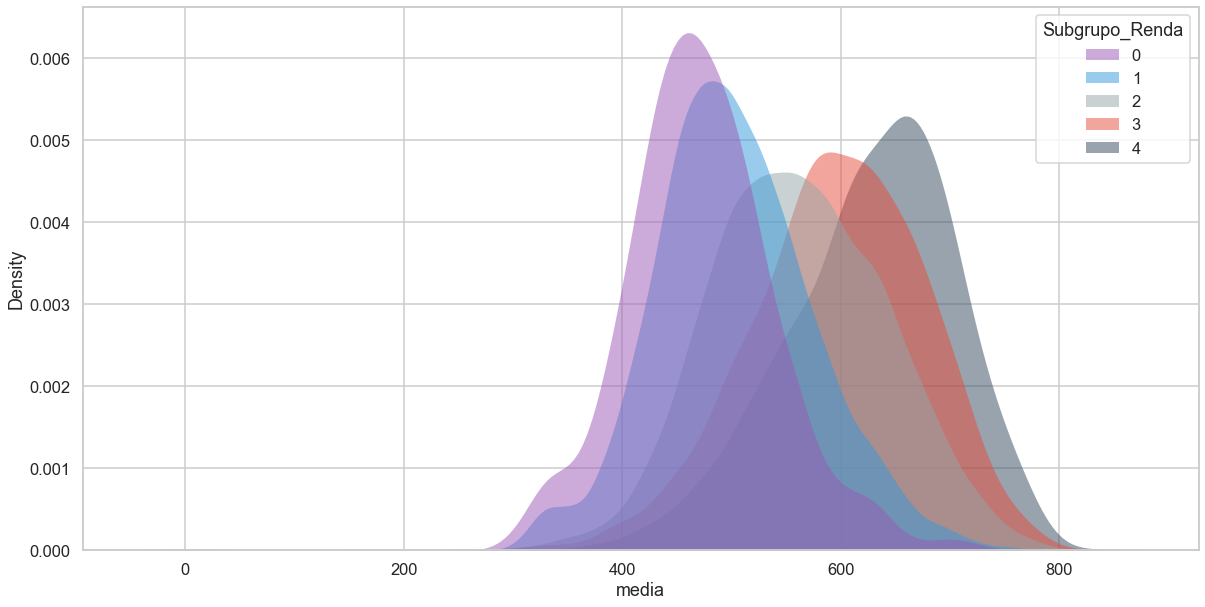

In [112]:
fig, ax = plt.subplots( figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10

sns.kdeplot(
   data=df, x="media", hue="Subgrupo_Renda",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
   palette=flatui
)
plt.show()

Como podemos ver, quanto maior a renda maior tende a ser a renda, mais negativo tende a ser o skewness da curva e, quanto menor a renda, mais positivo tende a ser. Isso mostra que a probabiilidade de obter notas boas é vai ficando progressivamente maior a medida que aumentamos o valor da faixa de renda. 

Vamos ver agora a distribuição de nota de acordo com a posse ou não de um aparelho celular por parte do aluno.

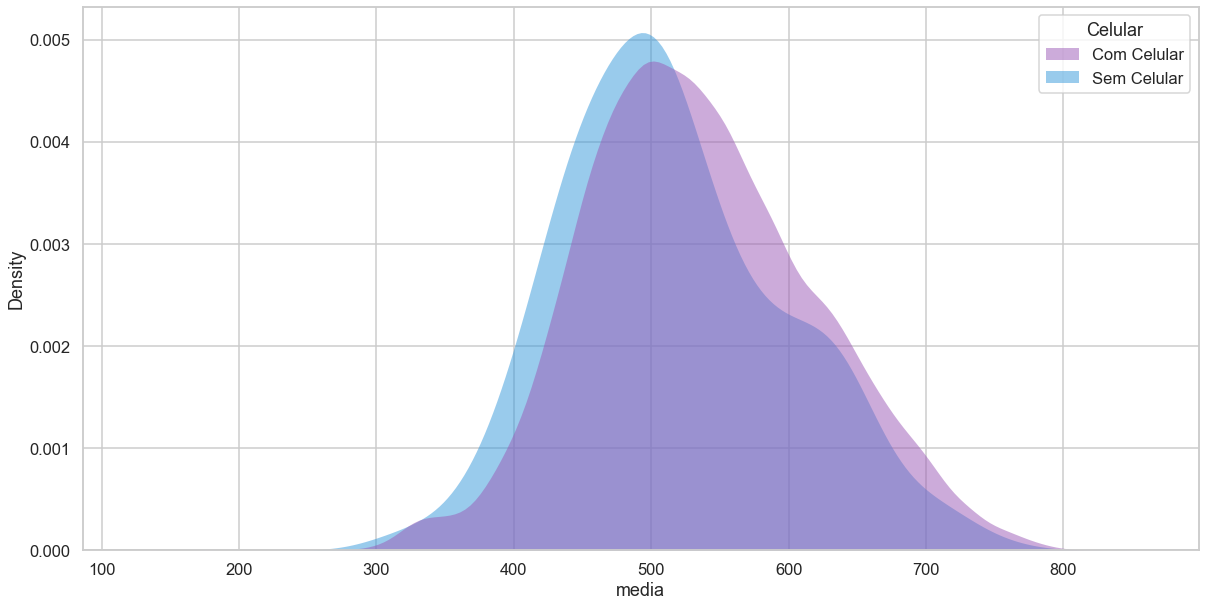

In [108]:
fig, ax = plt.subplots( figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10
cel_internet = df.loc[df['Q025'] == 'B']
cel_internet


sns.kdeplot(
   data=cel_internet, x="media", hue="Celular",
   fill=True, common_norm=False, 
   alpha=.5, linewidth=0,
)
plt.show()

Apesar das curvas estarem com distribuição semelhante quando fazemos uma análise agnóstica ao eixo das médias, podemos ver que a curva de quem possui celular está mais deslocada para direita, possuindo então um maior valor para as medidas de tendência central como média, moda e mediana. Além disso, a probabilidade de ser nota superior a 600 é bem maior no caso de selecionarmos aleatoriamente uma pessao com celular quando comparamos com quem não tem.

Vamos agora analisar como as curvas de comportam para pessoas com ou sem internet.

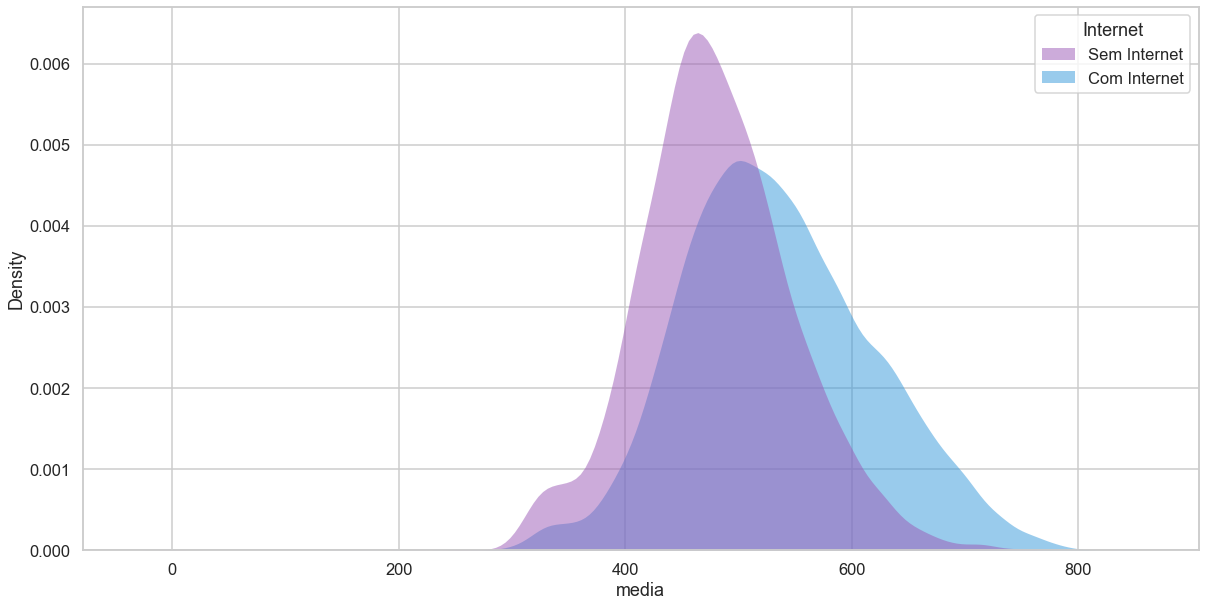

In [109]:
fig, ax = plt.subplots( figsize=(20, 10)) #cria uam figura com 1 linha, 2 colunas, de tamanho 20x10

sns.kdeplot(
   data= df,x="media", hue="Internet",
   fill=True, common_norm=False,
   alpha=.5, linewidth=0,
)
plt.show()

Aqui existe uma clara diferença, é nítido que, como esperado, ao selecionar aleatoriamente uma pessao com internet tem maior probabilidade de tirar nota alta do que uma sem internet. É importante lembrar que naõ necessariamente existe um fator de causalidade aqui, é bem mais provável de estarmos lidando com o caso de variável omitida. 

Por exemplo, como acesso a internet é dependente da renda, é bem mais provavel que a causalidade dessa distribuição esteja relacionada mais ao fator de renda do que necessariamente ao fator da internet. Porém, isso é só uma hipótese, a fim de fazer uma análise mais detalhada uma análise de causalidade deveria ser feita juntamente a alguns testes de hipótese.

Por fim, vamos plotar como a distribuição de pessoas pertencentes aos diversos grupos de renda varia entre o top 1% de melhores notas e os outros 99% da população analisada.

In [110]:
def compare_distribution(column, chart_title, legend_title):
    fig, ax = plt.subplots(figsize=(15, 3)) 
    # Define o título do gráfico e cria o gráfico
    ax.set_title(chart_title) 
    sns.histplot(df, y="TP_RANKING", hue=column, stat="probability", multiple="fill", shrink=0.8, ax=ax, edgecolor="none", palette=flatui)
    
    # Remove as linhas dos eixos
    sns.despine(left=True, bottom=True)
    
    # Remove o titulo do eixo vertical e define o do eixo horizontal
    ax.set_ylabel('') 
    ax.set_xlabel('Proporção') 
    
    # Muda a legenda de posição
    legends = re.findall(r"'(.*?)'", str(list(ax.get_legend().get_texts())))
    legends.reverse()
    plt.legend(legends, title=legend_title,bbox_to_anchor=(0.5,-0.4), loc='upper center', ncol=3)

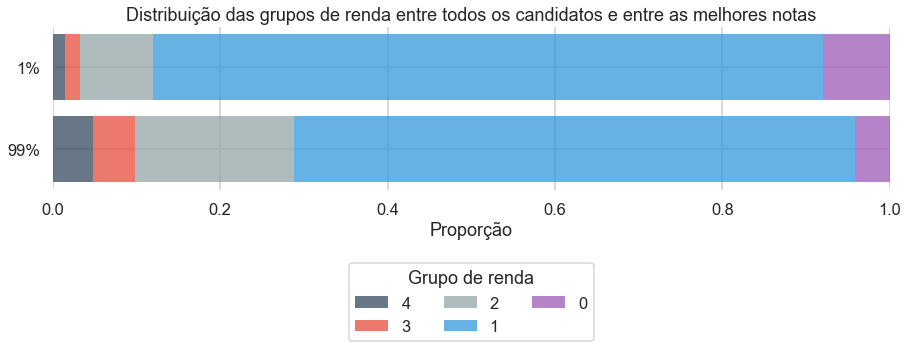

In [111]:
compare_distribution('Subgrupo_Renda', 'Distribuição das grupos de renda entre todos os candidatos e entre as melhores notas', 'Grupo de renda')
